**Table of contents**<a id='toc0_'></a>

- [Import Libraries](#toc1_1_)
  - [Get Data](#toc1_2_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


## <a id='toc1_1_'></a>[Import Libraries](#toc0_)


In [1]:
import pandas as pd
import numpy as np

# stats
from scipy.stats import gaussian_kde

# visualization
import matplotlib.pyplot as plt

# get data from TradingView
from tvDatafeed import TvDatafeed, Interval
from enum import Enum

tv = TvDatafeed()

you are using nologin method, data you access may be limited


In [2]:
class TimeFrame(Enum):
    DAILY = "daily"
    YEARLY = "yearly"


class Method(Enum):
    PERCENTAGE = "pct"
    HLO = "hlo"  # (high - low) / close

## <a id='toc1_2_'></a>[Get Data](#toc0_)


In [3]:
interval = Interval.in_daily

data = tv.get_hist(symbol="USOIL", exchange="TVC", interval=interval, n_bars=10_000)
data

,symbol,open,high,low,close,volume
datetime,,,,,,
1984-11-06 05:00:00,TVC:USOIL,28.540,28.720,28.51,28.700,0.0
1984-11-07 05:00:00,TVC:USOIL,28.820,28.870,28.58,28.730,0.0
1984-11-08 05:00:00,TVC:USOIL,28.670,28.700,28.53,28.680,0.0
1984-11-09 05:00:00,TVC:USOIL,28.580,28.620,28.50,28.530,0.0
1984-11-12 05:00:00,TVC:USOIL,28.420,28.500,28.39,28.420,0.0
...,...,...,...,...,...,...
2024-04-22 05:00:00,TVC:USOIL,81.825,82.250,80.74,82.078,0.0
2024-04-23 05:00:00,TVC:USOIL,82.120,83.400,80.91,83.328,0.0
2024-04-24 05:00:00,TVC:USOIL,83.305,83.665,82.46,82.753,0.0


In [4]:
START_YEAR = 2017
END_YEAR = 2024

# filtered year
filtered_data = data[(data.index.year >= START_YEAR) & (data.index.year <= END_YEAR)]

## Close Price Distribution

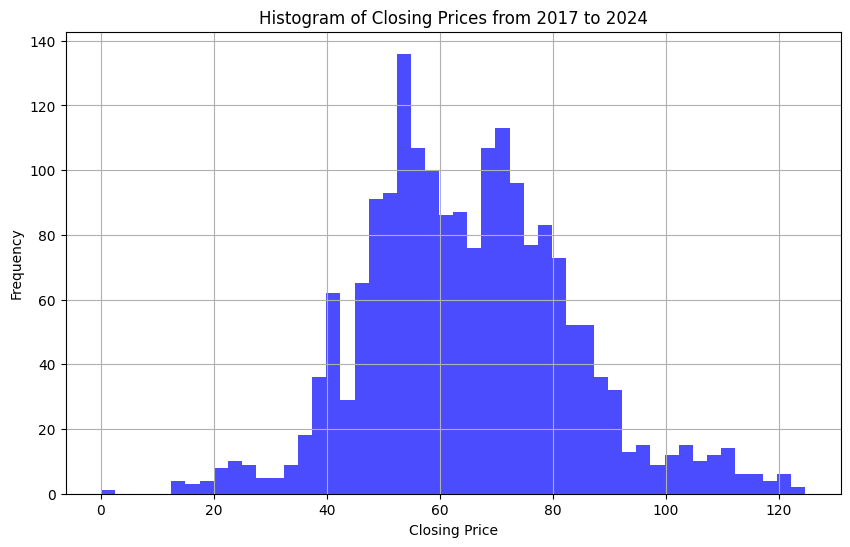

In [5]:
def plot_close_prices_histogram(
    data: pd.DataFrame,
    title=None,
    x_label="Closing Price",
    y_label="Frequency",
    grid=True,
):
    """Plot the close price histogram"""
    # Check if DataFrame index is of datetime type
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")

    plt.figure(figsize=(10, 6))
    plt.hist(data["close"], bins=50, color="blue", alpha=0.7)

    # customization
    if title:
        plt.title(title)
    else:
        plt.title(
            f"Histogram of Closing Prices from {data.index.year[0]} to {data.index.year[-1]}"
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if grid:
        plt.grid(True)


plot_close_prices_histogram(data=filtered_data)

### Stdev

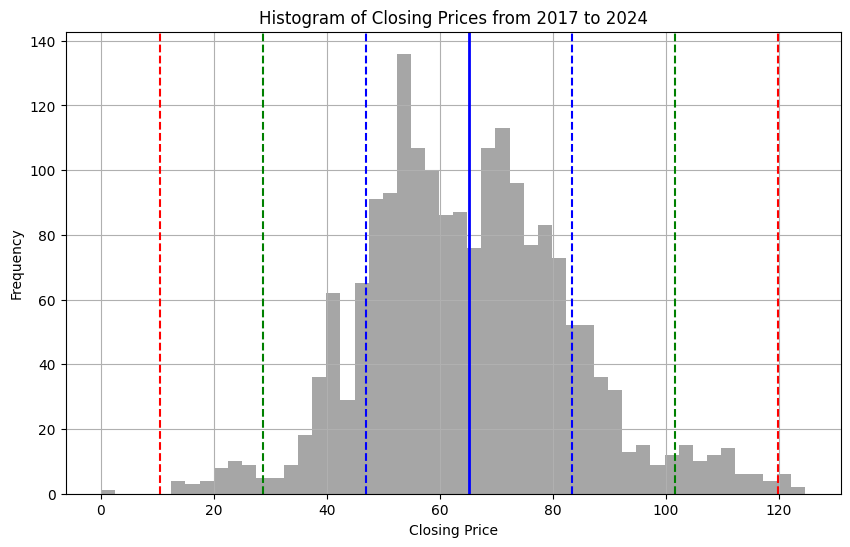

In [6]:
def plot_close_prices_histogram_with_stdev(
    data: pd.DataFrame,
    title=None,
    x_label="Closing Price",
    y_label="Frequency",
    grid=True,
):
    """Plot the close price histogram"""
    # Check if DataFrame index is of datetime type
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")

    mean = data["close"].mean()
    std = data["close"].std()
    stdev_pos_1, stdev_neg_1, stdev_pos_2, stdev_neg_2, stdev_pos_3, stdev_neg_3 = (
        _cal_stdev(mean=mean, std=std)
    )

    plt.figure(figsize=(10, 6))
    plt.hist(data["close"], bins=50, color="grey", alpha=0.7)

    # Add vertical lines for mean and SD ranges
    plt.axvline(mean, color="blue", linestyle="-", linewidth=2, label="Mean")
    plt.axvline(stdev_pos_1, color="blue", linestyle="--", label="Mean + 1SD")
    plt.axvline(stdev_neg_1, color="blue", linestyle="--", label="Mean - 1SD")
    plt.axvline(stdev_pos_2, color="green", linestyle="--", label="Mean + 2SD")
    plt.axvline(stdev_neg_2, color="green", linestyle="--", label="Mean - 2SD")
    plt.axvline(stdev_pos_3, color="red", linestyle="--", label="Mean + 3SD")
    plt.axvline(stdev_neg_3, color="red", linestyle="--", label="Mean - 3SD")

    # customization
    if title:
        plt.title(title)
    else:
        plt.title(
            f"Histogram of Closing Prices from {data.index.year[0]} to {data.index.year[-1]}"
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if grid:
        plt.grid(True)


def _cal_stdev(
    mean: float, std: float
) -> tuple[float, float, float, float, float, float]:
    stdev_pos_1 = mean + std
    stdev_neg_1 = mean - std
    stdev_pos_2 = mean + 2 * std
    stdev_neg_2 = mean - 2 * std
    stdev_pos_3 = mean + 3 * std
    stdev_neg_3 = mean - 3 * std

    return stdev_pos_1, stdev_neg_1, stdev_pos_2, stdev_neg_2, stdev_pos_3, stdev_neg_3


plot_close_prices_histogram_with_stdev(data=filtered_data[filtered_data["close"] > 0])

### Peak Density

Price Distribution year by year

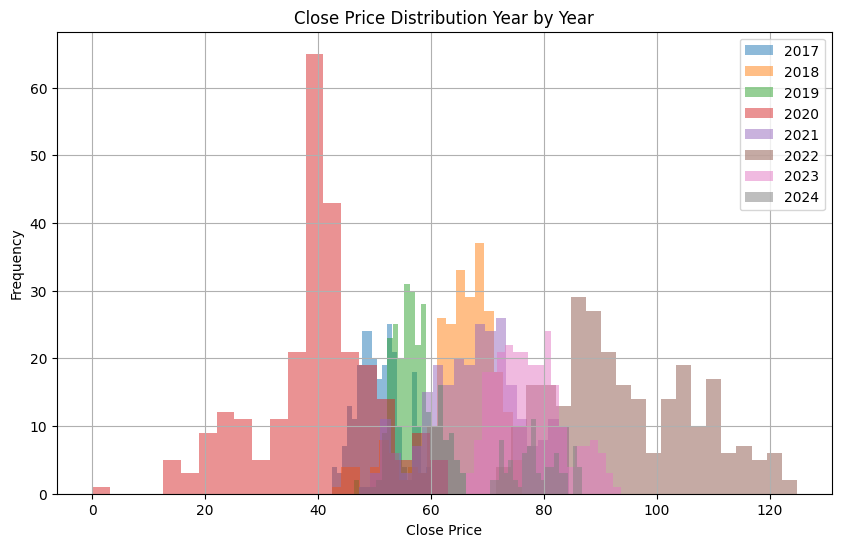

In [36]:
plt.figure(figsize=(10, 6))

filtered_data.loc[:, "year"] = filtered_data.index.year
for year, group_data in filtered_data.groupby("year"):
    plt.hist(group_data["close"], bins=20, alpha=0.5, label=str(year))

plt.title("Close Price Distribution Year by Year")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

Price Distribution and Peak value of kernel density

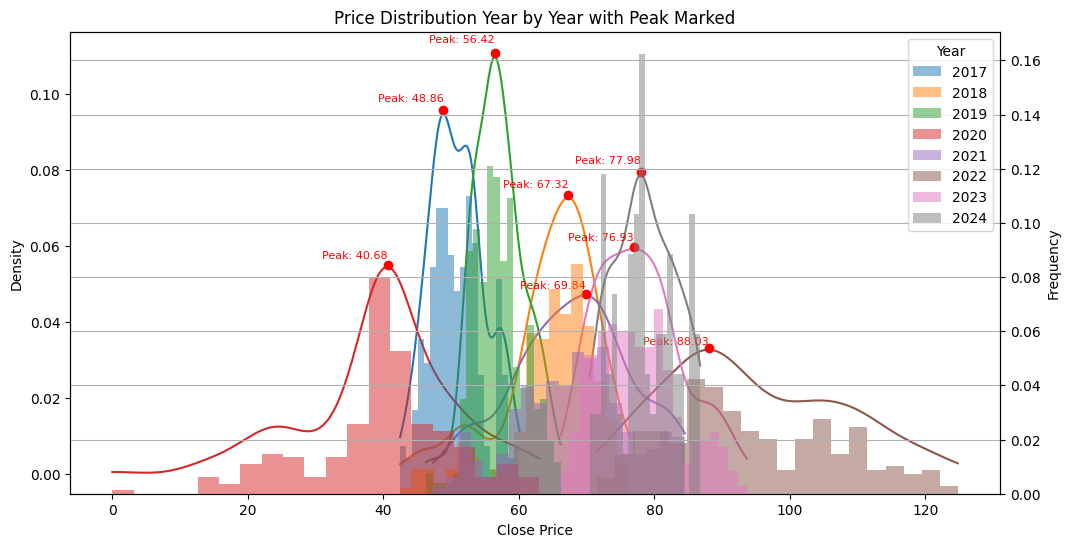

In [35]:
# Initialize a figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot kernel density estimate for each year
for year, group_data in filtered_data.groupby("year"):
    # Calculate KDE for the current year
    kde = gaussian_kde(group_data["close"])
    x_vals = np.linspace(group_data["close"].min(), group_data["close"].max(), 252)
    y_vals = kde(x_vals)

    # Plot KDE
    ax1.plot(x_vals, y_vals, label=str(year))

    # Find peak of KDE
    peak_index = np.argmax(y_vals)
    peak_value = y_vals[peak_index]
    peak_x = x_vals[peak_index]

    # Mark peak
    ax1.scatter(peak_x, peak_value * 1.01, color="red", zorder=5)
    ax1.text(
        peak_x,
        peak_value * 1.03,
        f"Peak: {peak_x:.2f}",
        color="red",
        fontsize=8,
        ha="right",
        va="bottom",
    )

ax1.set_xlabel("Close Price")
ax1.set_ylabel("Density")
# ax1.legend(title='Year', loc='upper right')

# Add second y-axis for price distribution
ax2 = ax1.twinx()
for year, group_data in filtered_data.groupby("year"):
    ax2.hist(group_data["close"], bins=20, alpha=0.5, label=str(year), density=True)

ax2.set_ylabel("Frequency")
ax2.legend(title="Year", loc="upper right")

plt.title("Price Distribution Year by Year with Peak Marked")
plt.grid(True)
plt.show()

## Stats Volatility


In [97]:
def cal_voltility(data: pd.DataFrame, timeframe=TimeFrame, method=Method) -> pd.Series:
    """
    Calculate the volatility of financial data.

    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame containing financial data, including columns for 'open', 'high', 'low', and 'close'.
    timeframe : TimeFrame, optional
        The timeframe over which to calculate volatility, either TimeFrame.DAILY or TimeFrame.YEARLY.
        Defaults to TimeFrame.DAILY.
    method : Method, optional
        The method to use for calculating volatility, either Method.PERCENTAGE or Method.HLO.
        Defaults to Method.PERCENTAGE.

    Returns
    -------
    pd.Series
        A pandas Series containing the calculated volatility.

    Raises
    ------
    ValueError
        If an invalid method is provided.
    """

    def _cal_method(data: pd.Series):
        return (
            data.groupby(data.index.year).std()
            if timeframe == TimeFrame.DAILY
            else data.groupby(data.index.year).std() * np.sqrt(252)
        )

    if method == Method.PERCENTAGE:
        volatility = data["close"].pct_change()
        return _cal_method(data=volatility)
    elif method == method.HLO:
        volatility = (data["high"] - data["low"]) / data["open"]
        return _cal_method(data=volatility)
    else:
        raise ValueError("Not found method!")


def cal_stats(data: pd.Series):
    """Calculate the min max and mean from the series data which normalized as percentage"""
    data_min = round(data.min(), 2)
    data_max = round(data.max(), 2)
    data_mean = round(data.mean(), 2)

    # Output
    print(f"min: {data_min}%\nmax: {data_max}%\nmean: {data_mean}%")

    return data_min, data_max, data_max

### Percentage Change


The standard deviation of daily returns for each year.


In [128]:
daily_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.DAILY, method=Method.PERCENTAGE)
    * 100
)

# filter blackswan
filtered_daily_volatility = daily_volatility[
    daily_volatility < daily_volatility.quantile(0.99)
]

# output
cal_stats(data=filtered_daily_volatility)
print(filtered_daily_volatility)

# show remove outlier
remove_indices = daily_volatility.index.difference(filtered_daily_volatility.index)
print(f"\nRemove out of quantile 99%: \n{daily_volatility[remove_indices]}")

min: 1.16%
max: 3.03%
mean: 2.05%
datetime
2013    1.161640
2014    1.441502
2015    2.710757
2016    2.920519
2017    1.538632
2018    1.997306
2019    1.964464
2021    2.220354
2022    3.025110
2023    2.098317
2024    1.434856
Name: close, dtype: float64

Remove out of quantile 99%: 
datetime
2020    8989.85588
Name: close, dtype: float64


The annualized standard deviation of returns for each year


In [129]:
annualized_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.YEARLY, method=Method.PERCENTAGE)
    * 100
)

# filter blackswan
filtered_annualized_volatility = annualized_volatility[
    annualized_volatility < annualized_volatility.quantile(0.99)
]
# output
cal_stats(data=filtered_annualized_volatility)
print(filtered_annualized_volatility)

# show remove outlier
remove_indices = annualized_volatility.index.difference(
    filtered_annualized_volatility.index
)
print(f"\nRemove out of quantile 99%: \n{annualized_volatility[remove_indices]}")

min: 18.44%
max: 48.02%
mean: 32.49%
datetime
2013    18.440470
2014    22.883138
2015    43.031938
2016    46.361802
2017    24.425026
2018    31.706256
2019    31.184894
2021    35.247026
2022    48.022139
2023    33.309755
2024    22.777638
Name: close, dtype: float64

Remove out of quantile 99%: 
datetime
2020    142709.537878
Name: close, dtype: float64


### (High - Low) / Open


The standard deviation of daily returns for each year.


In [131]:
daily_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.DAILY, method=Method.HLO) * 100
)

# filter blackswan
filtered_daily_volatility = daily_volatility[
    daily_volatility < daily_volatility.quantile(0.99)
]

# output
cal_stats(data=filtered_daily_volatility)
print(filtered_daily_volatility)

# show remove outlier
remove_indices = daily_volatility.index.difference(filtered_daily_volatility.index)
print(f"\nRemove out of quantile 99%: \n{annualized_volatility[remove_indices]}")

min: 0.65%
max: 2.07%
mean: 1.43%
datetime
2013    0.647634
2014    1.383171
2015    1.816340
2016    2.031555
2017    1.048406
2018    1.421185
2019    1.476174
2021    1.615932
2022    2.074662
2023    1.273501
2024    0.966900
dtype: float64

Remove out of quantile 99%: 
datetime
2020    142709.537878
Name: close, dtype: float64


The annualized standard deviation of returns for each year


In [132]:
annualized_volatility = (
    cal_voltility(filtered_data, timeframe=TimeFrame.YEARLY, method=Method.HLO) * 100
)

# filter blackswan
filtered_annualized_volatility = annualized_volatility[
    annualized_volatility < annualized_volatility.quantile(0.99)
]

# output
cal_stats(data=filtered_annualized_volatility)
print(filtered_annualized_volatility)

# show remove outlier
remove_indices = annualized_volatility.index.difference(
    filtered_annualized_volatility.index
)
print(f"\nRemove out of quantile 99%: {annualized_volatility[remove_indices]}")

min: 10.28%
max: 32.93%
mean: 22.74%
datetime
2013    10.280871
2014    21.957153
2015    28.833509
2016    32.249944
2017    16.642933
2018    22.560618
2019    23.433533
2021    25.652121
2022    32.934245
2023    20.216206
2024    15.349058
dtype: float64

Remove out of quantile 99%: datetime
2020    150.843986
dtype: float64


## Visualize Volatility

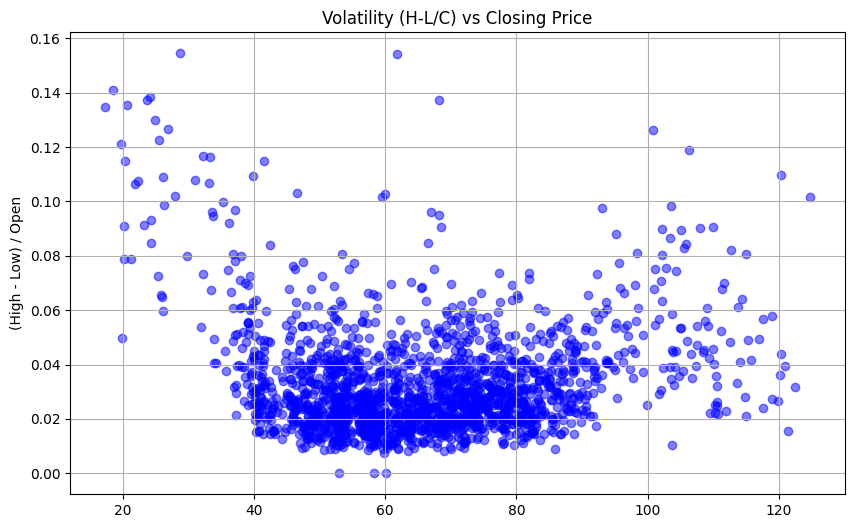

In [37]:
filtered_data.loc[:, "hlc"] = (
    filtered_data.loc[:, "high"] - filtered_data.loc[:, "low"]
) / filtered_data.loc[:, "open"]

# filter blackswan
filtered_data_volatility = filtered_data[
    filtered_data["hlc"] < filtered_data["hlc"].quantile(0.99)
]

# Create the dot plot
plt.figure(figsize=(10, 6))
plt.scatter(
    filtered_data_volatility["close"],
    filtered_data_volatility["hlc"],
    alpha=0.5,
    color="blue",
)
plt.title("Volatility (H-L/C) vs Closing Price")
plt.ylabel("(High - Low) / Open")
plt.grid(True)
plt.show()